<a href="https://colab.research.google.com/github/aplneto/IF1014/blob/main/03_Prepara%C3%A7%C3%A3o_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Antônio Paulino - apln2@cin.ufpe.br

Realizar as atividades de compreensão do problema, dos dados e a análise
exploratória para o domínio Credit Approval Data Set
(https://archive.ics.uci.edu/ml/datasets/Credit+Approval).
Apresentar relatórios com o itens mencionados e discussões com gráficos da base
de dados.
'''

DATA_FOLDER = (
    'https://archive.ics.uci.edu/ml/machine-learning-databases/'
    'credit-screening/'
)

DATA_DESCRIPTION = DATA_FOLDER + 'crx.names'
DATA_SET = DATA_FOLDER + 'crx.data'

In [ ]:
import pandas
import numpy

aliases = ['A%i' % i for i in range(1, 16)] + ['class']
data = pandas.read_csv(DATA_SET, names=aliases, na_values='?', header=None)
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,class
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


In [ ]:
continuous = data.describe().columns
categorical = data.drop(list(continuous) + ['class'], axis=1).columns
print(continuous)
print(categorical)

Index(['A2', 'A3', 'A8', 'A11', 'A14', 'A15'], dtype='object')
Index(['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13'], dtype='object')


# Limpeza dos dados

## Modelo de regressão linear para completar dados continuos faltantes

Variáveis continuas ausentes serão preenchidas por valores previstos a partir de um modelo de regressão linear construído a partir da coluna com valores ausentes e da coluna com todos os valores mais fortemente correlacionada a ela

In [ ]:
continuous_columns_missing_values = []

for column in continuous:
  if data[column].isnull().sum() > 0:
    continuous_columns_missing_values.append(column)

print(continuous_columns_missing_values)

['A2', 'A14']


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

No handles with labels found to put in legend.


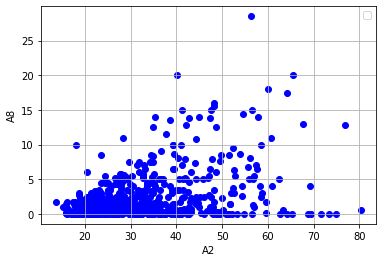

No handles with labels found to put in legend.


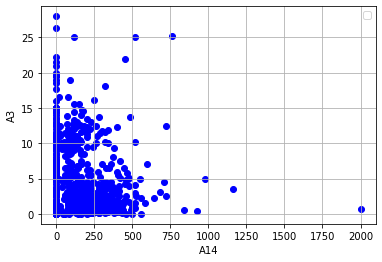

In [ ]:
most_correlated_columns = {}
candidates = [
  x for x in continuous if x not in continuous_columns_missing_values
]
for column in continuous_columns_missing_values:
  most_correlated_columns[column] = max(
      candidates, key=lambda x: abs(data[x].corr(data[column]))
  )
  fig, ax = plt.subplots()
  ax.scatter(data[column], data[most_correlated_columns[column]], color='blue')
  ax.legend()
  ax.grid(True)
  plt.xlabel(column)
  plt.ylabel(most_correlated_columns[column])
  plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
prediction_models = {}

for pair in most_correlated_columns.items():
  rows = data[~data[list(pair)].isnull().any(axis=1)][list(pair)]
  y = rows[pair[0]]
  x = rows[pair[1]]
  lr = LinearRegression()
  lr.fit(x.values.reshape(-1, 1), y)
  d = pandas.DataFrame(data= {
      'value' : lr.predict(data[pair[1]].values.reshape(-1, 1))
  })
  data[pair[0]] = numpy.where(data[column].isna(), d['value'], data[column])

data[continuous].isna().sum()

A2     0
A3     0
A8     0
A11    0
A14    0
A15    0
dtype: int64

# Dados categóricos

Algoritmos de machine learning esperam que os dados estejam em formato numérico, por esse motivo, as variáveis categóricas do dataset foram convertidas em números inteiros usando o LabelEncoder da biblioteca sklearn.

Os valores ausentes foram completados usando um algoritmo de árvore de decisão

In [ ]:
categorical_columns_missing_values = [
  p[0] for p in dict(data[categorical].isna().sum() > 0).items() if p[1]
]
complete_data = data.dropna()
print(categorical_columns_missing_values)

['A1', 'A4', 'A5', 'A6', 'A7']


In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

label_dict = defaultdict(LabelEncoder)
complete_data = complete_data.apply(
    lambda x: label_dict[x.name].fit_transform(x)
    if x.name in list(categorical) + ['class']
    else x
)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
trees = {}
X = complete_data.drop(categorical_columns_missing_values, axis=1)
for column in categorical_columns_missing_values:
  Y = complete_data[column]
  tree = DecisionTreeClassifier(
      max_leaf_nodes=Y.nunique(), random_state=2**Y.nunique()
  )
  trees[column] = tree
  tree.fit(X.values, Y.values)

In [ ]:
for column in trees:
  tree = trees[column]
  encoder = label_dict[column]
  d = pandas.DataFrame(data= {
      'value' : encoder.inverse_transform(
          tree.predict(
          data.drop(categorical_columns_missing_values, axis=1).apply(
                  lambda x: label_dict[x.name].fit_transform(x)
                  if x.name in list(categorical) + ['class']
                  else x
          ).values
        )
      )
    }
  )

  data[column] = numpy.where(data[column].isna(), d['value'], data[column])

In [ ]:
labels = data['class']
data.drop('class', axis=1, inplace=True)
X = data.apply(
    lambda x: label_dict[x.name].fit_transform(x)
    if x.name in categorical
    else x
)
print(X)

     A1     A2      A3  A4  A5  A6  A7  ...  A9  A10  A11  A12  A13    A14  A15
0     1  202.0   0.000   1   0  12   7  ...   1    1    1    0    0  202.0    0
1     0   43.0   4.460   1   0  10   3  ...   1    1    6    0    0   43.0  560
2     0  280.0   0.500   1   0  10   3  ...   1    0    0    0    0  280.0  824
3     1  100.0   1.540   1   0  12   7  ...   1    1    5    1    0  100.0    3
4     1  120.0   5.625   1   0  12   7  ...   1    0    0    0    2  120.0    0
..   ..    ...     ...  ..  ..  ..  ..  ...  ..  ...  ...  ...  ...    ...  ...
685   1  260.0  10.085   2   2   4   3  ...   0    0    0    0    0  260.0    0
686   0  200.0   0.750   1   0   1   7  ...   0    1    2    1    0  200.0  394
687   0  200.0  13.500   2   2   5   2  ...   0    1    1    1    0  200.0    1
688   1  280.0   0.205   1   0   0   7  ...   0    0    0    0    0  280.0  750
689   1    0.0   3.375   1   0   1   3  ...   0    0    0    1    0    0.0    0

[690 rows x 15 columns]


# Codificação One Hot dos rótulos 

In [ ]:
Y = pandas.get_dummies(labels, prefix='', prefix_sep='')
print(Y)

     +  -
0    1  0
1    1  0
2    1  0
3    1  0
4    1  0
..  .. ..
685  0  1
686  0  1
687  0  1
688  0  1
689  0  1

[690 rows x 2 columns]


# Transformação dos Dados

* Uma vez que as variáveis continuas possuem valores entre 0 e um determinado limite, estes serão normalizados entre os valores 0.0 e 1.0 para análise de diminuição de dimensionalidade

In [ ]:
X[continuous].describe()

,A2,A3,A8,A11,A14,A15
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000
mean,181.120217,4.758725,2.223406,2.40000,184.094523,1017.385507
std,173.424884,4.978163,3.346513,4.86294,172.233363,5210.102598
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,60.000000,1.000000,0.165000,0.00000,80.000000,0.000000
50%,160.000000,2.750000,1.000000,0.00000,160.000000,5.000000
75%,272.000000,7.207500,2.625000,3.00000,272.000000,395.500000
max,2000.000000,28.000000,28.500000,67.00000,2000.000000,100000.000000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scalers = defaultdict(MinMaxScaler)

for column in continuous:
  scaler = scalers[column]
  X[column] = scaler.fit_transform(X[column].values.reshape(-1, 1))

X[continuous].describe()

,A2,A3,A8,A11,A14,A15
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.090560,0.169954,0.078014,0.035821,0.092047,0.010174
std,0.086712,0.177792,0.117422,0.072581,0.086117,0.052101
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030000,0.035714,0.005789,0.000000,0.040000,0.000000
50%,0.080000,0.098214,0.035088,0.000000,0.080000,0.000050
75%,0.136000,0.257411,0.092105,0.044776,0.136000,0.003955
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Redução de dimensionalidade

<!--

* https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

 -->

## Principal component analysis

<!--

* https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis
* https://www.youtube.com/watch?v=FgakZw6K1QQ
* https://jmausolf.github.io/code/pca_in_python/

-->

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
pca.fit(X[continuous])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

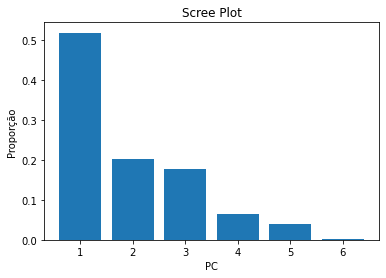

[0.51882662 0.72086079 0.89713674 0.96058855 0.99911707 1.        ]


In [ ]:
PC_values = numpy.arange(pca.n_components_)+1
plt.bar(PC_values, pca.explained_variance_ratio_)
plt.title("Scree Plot")
plt.xlabel("PC")
plt.ylabel("Proporção")
plt.show()

print(numpy.cumsum(pca.explained_variance_ratio_))

A partir da análise PCA é possível concluir que uma representação com os componentes principais PC1, PC2, PC3 e PC4 são repsonsáveis por 96% da variabilidade do dataset e podem ser usados para representar os dados com um elevado nível de fidelidade.

In [ ]:
loadings = pandas.DataFrame(
    pca.components_.T,
    columns = ['PC%d' % (i) for i in numpy.arange(pca.n_components_)+1], index=X[continuous].columns
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
A2,-0.166156,0.669505,-0.161869,0.029509,-0.042523,-0.703757
A3,0.914783,0.139948,-0.370799,-0.065913,-0.041781,0.002205
A8,0.293551,0.297251,0.877573,-0.235164,0.005647,0.001427
A11,0.141225,0.040084,0.198702,0.966984,-0.062428,0.003405
A14,-0.168426,0.662511,-0.162094,0.025800,-0.033185,0.710401
A15,0.032866,0.057373,-0.020393,0.061316,0.995699,-0.006081


In [ ]:
pca_X = pandas.DataFrame(
    data = pca.fit_transform(X[continuous]),
    columns = ['PC%d' % (i) for i in numpy.arange(pca.n_components_)+1]
)

max_column = numpy.argmax(numpy.cumsum(pca.explained_variance_ratio_) > 0.9) + 1
principal_components = pca_X.columns[:max_column:]

pca_X = pandas.concat(
    [pca_X[principal_components], X[categorical]],
    axis = 1
)

pca_X

,PC1,PC2,PC3,PC4,A1,A4,A5,A6,A7,A9,A10,A12,A13
0,-0.172025,-0.022438,0.025960,-0.001056,1,1,0,12,7,1,1,0,0
1,0.029446,-0.084059,0.062484,0.041784,0,1,0,10,3,1,1,0,0
2,-0.168001,0.034492,0.011268,-0.016066,0,1,0,10,3,1,0,0,0
3,-0.070466,-0.054204,0.110931,0.029602,1,1,0,12,7,1,1,1,0
4,0.028096,-0.044736,-0.024050,-0.034794,1,1,0,12,7,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.145649,0.065999,-0.119954,-0.037625,1,2,2,4,3,0,0,0,0
686,-0.137225,-0.011374,0.042331,0.005609,0,1,0,1,7,0,1,1,0
687,0.277091,0.051528,-0.129400,-0.039079,0,2,2,5,2,0,1,1,0
688,-0.192701,0.017747,-0.029766,-0.003370,1,1,0,0,7,0,0,0,0


### Visualizacão dos dados usando combinações de dois componentes

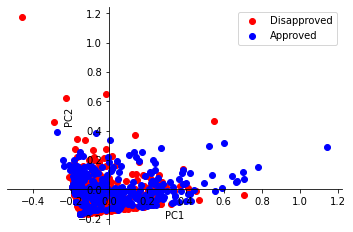

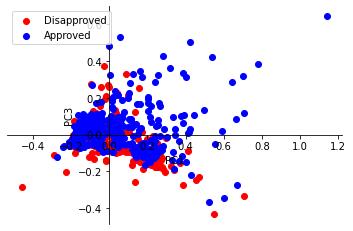

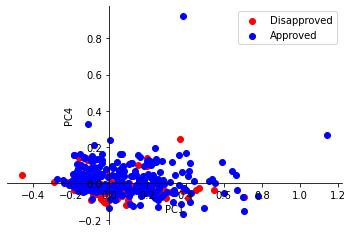

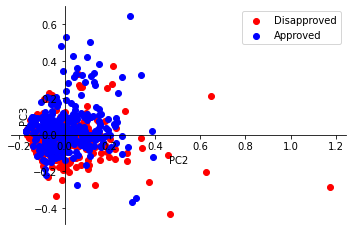

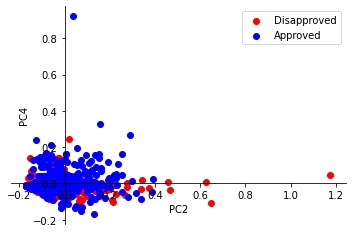

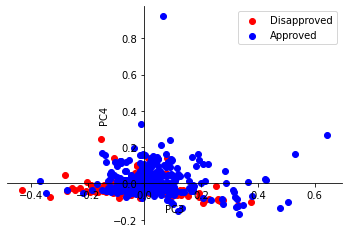

In [ ]:
vis = pandas.concat([pca_X[principal_components], labels], axis=1)

for n, column_x in enumerate(pca_X[principal_components].columns):
  for column_y in pca_X[principal_components].columns[n+1:]:
    fig, ax = plt.subplots()
    appr = vis[[column_x, column_y]].where(vis['class'] == '+')
    disa = vis[[column_x, column_y]].where(vis['class'] == '-')
    ax.scatter(disa[column_x], disa[column_y], color='red', label='Disapproved')
    ax.scatter(appr[column_x], appr[column_y], color='blue', label='Approved')

    # set the x-spine (see below for more info on `set_position`)
    ax.spines['left'].set_position('zero')
    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()
    # set the y-spine
    ax.spines['bottom'].set_position('zero')
    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()

    ax.legend()
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()

## Linear Discriminant Analysis

<!--

* https://www.youtube.com/watch?v=azXCzI57Yfc

* https://aaronschlegel.me/discriminant-analysis-group-separation.html

* https://aaronschlegel.me/linear-discriminant-analysis-classification-two-groups.html

* https://aaronschlegel.me/discriminant-analysis-several-groups.html

 -->

In [ ]:
# targets = pandas.DataFrame(data = {'class' : LabelEncoder().fit_transform(labels)})


# lda = LinearDiscriminantAnalysis('svd', n_components=2)
# lda.fit(X[continuous], targets)
# lda_X = lda.transform(X[continuous])

# Divisão entre dados de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    pca_X, Y, test_size = 0.2, random_state = 4
)

In [ ]:
print(X_train.shape)
print(Y_train.shape)